In [48]:
import sys
import numpy as np
import time
import os
import sys
import random
import gc
import scipy.ndimage as ndimage
from skimage.transform import resize
import matplotlib.pyplot as plt

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener
from deepmass import cnn_keras as cnn

plt.rcParams['image.cmap'] = 'coolwarm'


In [49]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [50]:
map_size = 256
n_test = int(500)
n_epoch = 50
batch_size = 64
learning_rate = 1e-4

foreground_amplitude_rescale = 253775.
T_mean_cmb = 2.726*1e6

In [51]:
input_foreground_array = np.load('../foregrounds/foreground_synth_test.npy')
gc.collect()

for i in range(input_foreground_array.shape[0]):
    if i%(int(input_foreground_array.shape[0]/10))==0: print(i, flush=True)
    input_foreground_array[i,:,:] = ndimage.gaussian_filter(np.exp(input_foreground_array[i,:,:]), 1)
    
input_foreground_array = np.expand_dims(input_foreground_array, 3)

rotated_foreground_array = np.copy(input_foreground_array)
for i in range(3):
    rotated_foreground_array = np.concatenate([rotated_foreground_array,
                                               tf.image.rot90(input_foreground_array, k = i+1)])

rotated_foreground_array = np.concatenate([rotated_foreground_array,
                                           tf.image.transpose(rotated_foreground_array)])
print(rotated_foreground_array.shape)
gc.collect()

0
2
4
6
8
10
12
14
16
18
(160, 512, 512, 1)


0

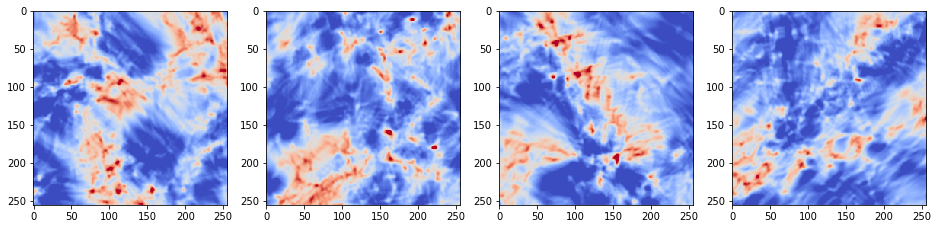

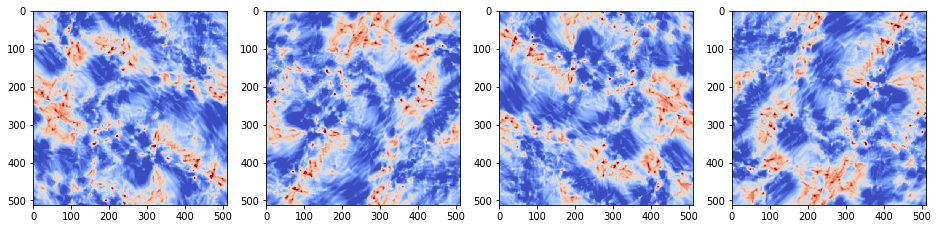

In [59]:
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(rotated_foreground_array[i*20,:,:,0], clim=(0.8,1.6))
plt.show()

plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(rotated_foreground_array[i*20+80,:,:,0], clim=(0.8,1.6))
plt.show()

In [62]:
grid_step = np.meshgrid(np.linspace(0,512-map_size,10, dtype=int)[:-1],np.linspace(0,512-map_size,10, dtype=int)[:-1])
grid_i_index = grid_step[0].flatten()
grid_j_index = grid_step[0].flatten()
print(len(grid_i_index))
noisy_array = np.empty((len(grid_i_index)*rotated_foreground_array.shape[0], map_size,map_size,1), dtype=np.float32)
for i in range(len(grid_i_index)):
    print(i*rotated_foreground_array.shape[0], grid_i_index[i], grid_j_index[i]) 
    low_lim = i*rotated_foreground_array.shape[0]
    high_lim = (i+1)*rotated_foreground_array.shape[0]
    noisy_array[low_lim:high_lim] = rotated_foreground_array[:,
                                                             grid_i_index[i]:(grid_i_index[i]+map_size),
                                                             grid_j_index[i]:(grid_j_index[i]+map_size)]
    
noisy_array = (noisy_array - np.mean(noisy_array))/(20*np.std(noisy_array))

clean_array = np.load('../foregrounds/map_256_041219.npy', mmap_mode='r+')
clean_array = clean_array[:noisy_array.shape[0]].astype(np.float32)
gc.collect()

for i in range(clean_array.shape[0]):
    if i%(int(clean_array.shape[0]/10))==0: print(i, flush=True)
    clean_array[i,:,:,0] = ndimage.gaussian_filter(clean_array[i,:,:,0], 1)
gc.collect()
clean_array = clean_array[:,:map_size,:map_size,:]
clean_array = (clean_array - np.mean(clean_array))/(30*np.std(clean_array)) + 0.5
noisy_array = noisy_array + clean_array + 0.1

test_array_noisy = noisy_array[:n_test]
test_array_clean = clean_array[:n_test]
gc.collect()

noisy_array = noisy_array[n_test:]
clean_array = clean_array[n_test:]
gc.collect()

81
0 0 0
160 28 28
320 56 56
480 85 85
640 113 113
800 142 142
960 170 170
1120 199 199
1280 227 227
1440 0 0
1600 28 28
1760 56 56
1920 85 85
2080 113 113
2240 142 142
2400 170 170
2560 199 199
2720 227 227
2880 0 0
3040 28 28
3200 56 56
3360 85 85
3520 113 113
3680 142 142
3840 170 170
4000 199 199
4160 227 227
4320 0 0
4480 28 28
4640 56 56
4800 85 85
4960 113 113
5120 142 142
5280 170 170
5440 199 199
5600 227 227
5760 0 0
5920 28 28
6080 56 56
6240 85 85
6400 113 113
6560 142 142
6720 170 170
6880 199 199
7040 227 227
7200 0 0
7360 28 28
7520 56 56
7680 85 85
7840 113 113
8000 142 142
8160 170 170
8320 199 199
8480 227 227
8640 0 0
8800 28 28
8960 56 56
9120 85 85
9280 113 113
9440 142 142
9600 170 170
9760 199 199
9920 227 227
10080 0 0
10240 28 28
10400 56 56
10560 85 85
10720 113 113
10880 142 142
11040 170 170
11200 199 199
11360 227 227
11520 0 0
11680 28 28
11840 56 56
12000 85 85
12160 113 113
12320 142 142
12480 170 170
12640 199 199
12800 227 227
0
1296
2592
3888
5184
648

0

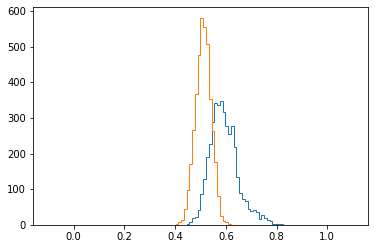

In [63]:
_ = plt.hist(noisy_array.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')
_ = plt.hist(clean_array.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')

In [64]:
train_gen = cnn.BatchGenerator(noisy_array, clean_array, gen_batch_size=batch_size)
test_gen = cnn.BatchGenerator(test_array_noisy, test_array_clean, gen_batch_size=batch_size)

cnn_instance = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate)
cnn_model = cnn_instance.model()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 256, 256, 16) 64          conv2d_30[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_12 (AveragePo (None, 128, 128, 16) 0           batch_normalization_27[0][0]     
____________________________________________________________________________________________

In [65]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=n_epoch,
                         steps_per_epoch=np.ceil(noisy_array.shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(test_array_noisy.shape[0] / int(batch_size)))

gc.collect()

Epoch 1/50
195/195 [==============================] - 31s 149ms/step - loss: 0.0111 - val_loss: 0.0024
Epoch 2/50
195/195 [==============================] - 28s 146ms/step - loss: 9.3531e-04 - val_loss: 8.5201e-04
Epoch 3/50
195/195 [==============================] - 29s 147ms/step - loss: 6.0128e-04 - val_loss: 6.1217e-04
Epoch 4/50
195/195 [==============================] - 29s 147ms/step - loss: 4.8726e-04 - val_loss: 4.5815e-04
Epoch 5/50
195/195 [==============================] - 29s 147ms/step - loss: 4.2984e-04 - val_loss: 4.1185e-04
Epoch 6/50
195/195 [==============================] - 29s 147ms/step - loss: 3.9412e-04 - val_loss: 3.8593e-04
Epoch 7/50
195/195 [==============================] - 29s 147ms/step - loss: 3.7192e-04 - val_loss: 3.6406e-04
Epoch 8/50
195/195 [==============================] - 29s 148ms/step - loss: 3.5620e-04 - val_loss: 3.5444e-04
Epoch 9/50
195/195 [==============================] - 29s 148ms/step - loss: 3.4447e-04 - val_loss: 3.4407e-04
Epoch 10/

22016

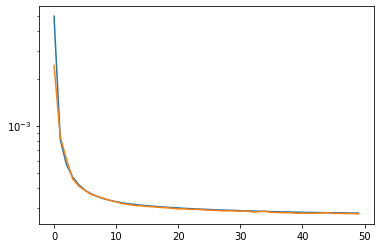

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [67]:
test_output = cnn_model.predict(noisy_array[10000:10002])

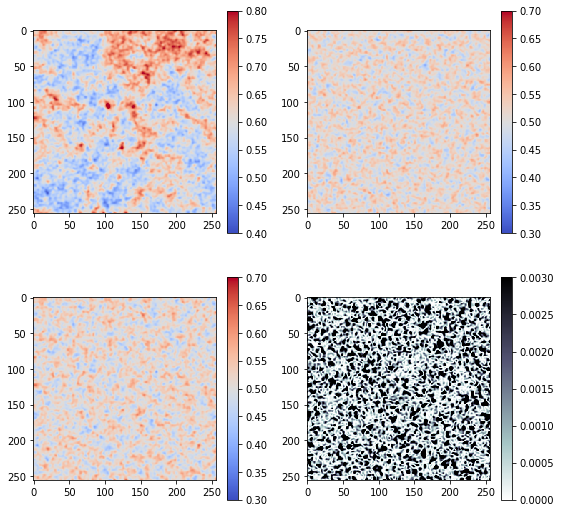

In [101]:
_ = plt.figure(figsize=(9,9))
_ = plt.subplot(221), plt.imshow(noisy_array[10000,:,:,0], clim=(0.4,0.8)), plt.colorbar()
_ = plt.subplot(222), plt.imshow(test_output[0,:,:,0], clim=(0.3,0.7)), plt.colorbar()
_ = plt.subplot(223), plt.imshow(clean_array[10000,:,:,0], clim=(0.3,0.7)), plt.colorbar()
_ = plt.subplot(224), plt.imshow((clean_array[10000,:,:,0]-test_output[0,:,:,0])**2, clim=(0,3e-3), cmap='bone_r')
_ = plt.colorbar()

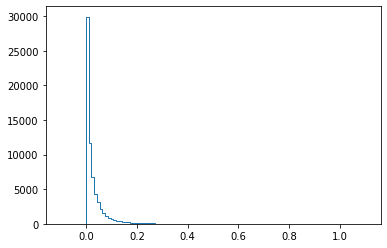

In [69]:
target_var = 100*(cnn_model.predict(noisy_array) - clean_array)**2.
_ = plt.hist(target_var[0,:,:,0].flatten(),bins=np.linspace(-0.1,1.1,111), histtype='step')

In [70]:
train_gen_var = cnn.BatchGenerator(noisy_array[:10000], target_var[:10000], gen_batch_size=batch_size)
test_gen_var = cnn.BatchGenerator(noisy_array[10000:], target_var[10000:], gen_batch_size=batch_size)

cnn_instance_var = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate)
cnn_model_var = cnn_instance_var.model()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 16) 64          conv2d_40[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_16 (AveragePo (None, 128, 128, 16) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [71]:
history_var = cnn_model_var.fit_generator(generator=train_gen_var,
                         epochs=n_epoch,
                         steps_per_epoch=np.ceil(noisy_array[:10000].shape[0] / int(batch_size)),
                         validation_data=test_gen_var,
                         validation_steps=np.ceil(noisy_array[10000:].shape[0] / int(batch_size)))

gc.collect()

Epoch 1/50
157/157 [==============================] - 27s 168ms/step - loss: 0.0886 - val_loss: 0.0065
Epoch 2/50
157/157 [==============================] - 25s 159ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 3/50
157/157 [==============================] - 25s 160ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/50
157/157 [==============================] - 25s 160ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/50
157/157 [==============================] - 25s 160ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/50
157/157 [==============================] - 25s 160ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/50
157/157 [==============================] - 25s 160ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/50
157/157 [==============================] - 25s 160ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/50
157/157 [==============================] - 25s 159ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/50
157/157 [==============================] - 25s 161ms/step - l

KeyboardInterrupt: 

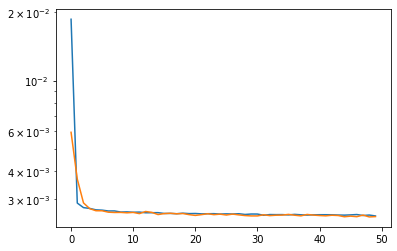

In [72]:
plt.plot(history_var.history['loss'])
plt.plot(history_var.history['val_loss'])
plt.yscale('log')

(0.0024, 0.0028)

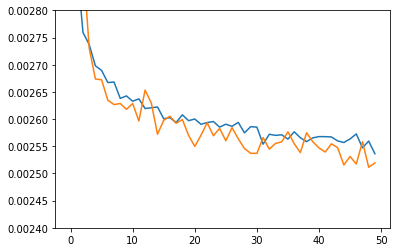

In [73]:
plt.plot(history_var.history['loss'])
plt.plot(history_var.history['val_loss'])
plt.ylim(2.4e-3,2.8e-3)

In [74]:
test_var = cnn_model_var.predict(noisy_array[10000:10002])

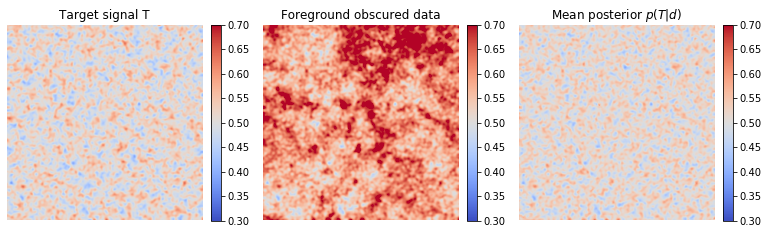

In [75]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1), plt.imshow(clean_array[10000,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Target signal T'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(noisy_array[10000,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow(test_output[0,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(T | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_planck.png', dpi=300)

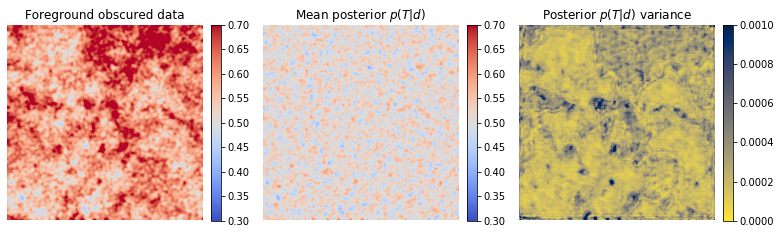

In [76]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1),  plt.imshow(noisy_array[10000,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(test_output[0,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(T | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow(test_var[0,:,:,0]/100., clim = (0.,1e-3),interpolation='spline16', cmap = 'cividis_r')
_ = plt.title('Posterior $p(T | d)$ variance'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_var_planck.png', dpi=300)

In [90]:
input_patch_example = np.load('../../CompSepAlgo/data/patch_0.npy')
input_patch_example = ndimage.gaussian_filter(np.exp(input_patch_example), 1)
input_patch_example = (input_patch_example - np.mean(input_patch_example))/(20*np.std(input_patch_example))
input_patch_example = np.reshape(input_patch_example[128:-128,128:-128], (1,256,256,1))
input_signal_example = np.reshape(test_array_clean[0], (1,256,256,1))
input_patch_example = input_patch_example + input_signal_example + 0.1

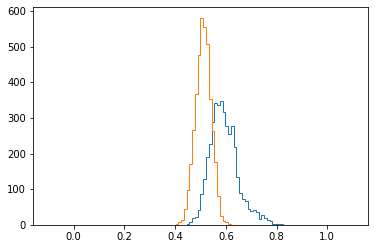

In [97]:
_ = plt.hist(noisy_array.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')
_ = plt.hist(clean_array.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')

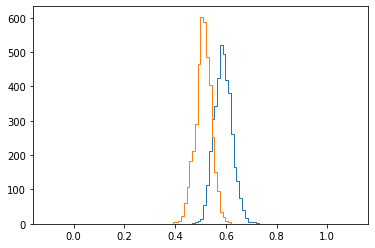

In [98]:
_ = plt.hist(input_patch_example.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')
_ = plt.hist(input_signal_example.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')

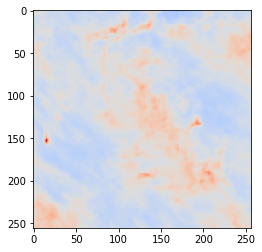

In [102]:
plt.imshow(input_patch_example[0,:,:,0]-input_signal_example[0,:,:,0]+0.5, clim=(0.4,0.8))

In [103]:
test_output = cnn_model.predict(input_patch_example)
test_var = cnn_model_var.predict(input_patch_example)

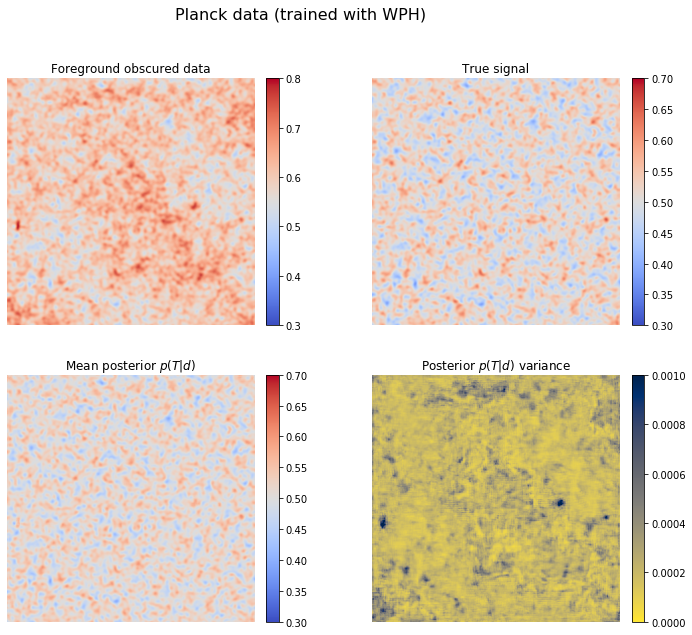

In [110]:
_ = plt.figure(figsize=(12,10))
_ = plt.suptitle('Planck data (trained with WPH)', fontsize=16)
_ = plt.subplot(2,2,1),  plt.imshow(input_patch_example[0,5:-5,5:-5,0], clim=(0.3,0.8),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,2),  plt.imshow(input_signal_example[0,5:-5,5:-5,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('True signal'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,3), plt.imshow(test_output[0,5:-5,5:-5,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(T | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,4), plt.imshow(test_var[0,5:-5,5:-5,0]/100., clim = (0.,1e-3),interpolation='spline16', cmap = 'cividis_r')
_ = plt.title('Posterior $p(T | d)$ variance'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_var_planck.png', dpi=300)

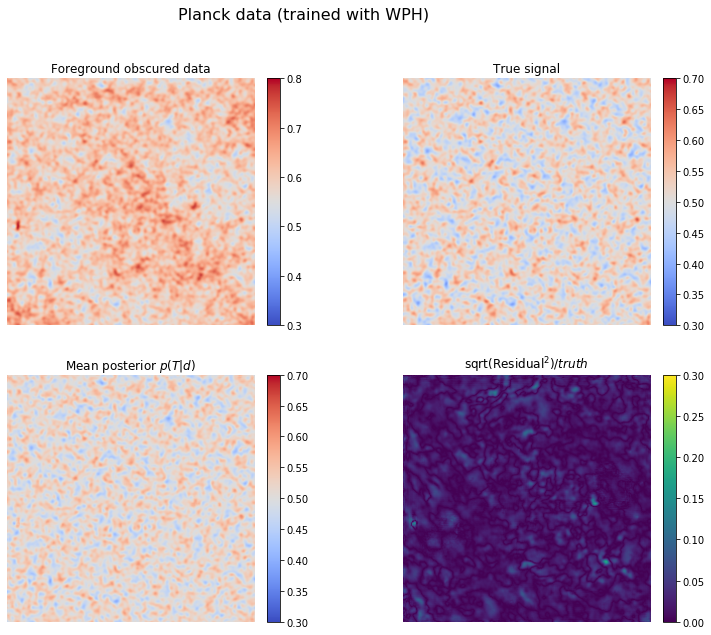

In [121]:
_ = plt.figure(figsize=(13,10))
_ = plt.suptitle('Planck data (trained with WPH)', fontsize=16)
_ = plt.subplot(2,2,1),  plt.imshow(input_patch_example[0,5:-5,5:-5,0], clim=(0.3,0.8),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,2),  plt.imshow(input_signal_example[0,5:-5,5:-5,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('True signal'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,3), plt.imshow(test_output[0,5:-5,5:-5,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(T | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,4), plt.imshow(np.sqrt((input_signal_example[0,5:-5,5:-5,0]-test_output[0,5:-5,5:-5,0])**2)/input_signal_example[0,5:-5,5:-5,0],clim=(0.,0.3),
                                   interpolation='spline16',cmap = 'viridis')
_ = plt.title(r'sqrt(Residual$^2)/truth$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_var_planck2.png', dpi=300)